In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

In [5]:
!cp -r /content/drive/MyDrive/ML_PROJECTS/Competitions/Loan_Payback_Prediction/dataset.zip /content/

In [7]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [8]:
train_df = pd.read_csv('/content/train.csv')
train_df.sample(5)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
390216,390216,51575.30,0.037,675,17705.45,13.36,Male,Married,Bachelor's,Employed,Business,C1,1.0
308556,308556,29159.61,0.052,725,12772.16,10.86,Female,Single,Bachelor's,Unemployed,Debt consolidation,C1,1.0
98774,98774,32363.12,0.091,588,14558.59,13.24,Female,Married,High School,Employed,Other,E5,1.0
319236,319236,9236.58,0.117,684,23951.25,12.81,Female,Single,High School,Employed,Medical,C3,1.0
45064,45064,30215.09,0.111,740,7682.41,13.67,Male,Married,Master's,Self-employed,Debt consolidation,B3,1.0


In [9]:
train_df.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back'],
      dtype='object')

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [11]:
train_df.isna().sum()

,0
id,0
annual_income,0
debt_to_income_ratio,0
credit_score,0
loan_amount,0
interest_rate,0
gender,0
marital_status,0
education_level,0
employment_status,0


In [12]:
len(train_df), train_df.shape

(593994, (593994, 13))

In [13]:
train_df.dtypes

,0
id,int64
annual_income,float64
debt_to_income_ratio,float64
credit_score,int64
loan_amount,float64
interest_rate,float64
gender,object
marital_status,object
education_level,object
employment_status,object


<Axes: xlabel='loan_paid_back'>

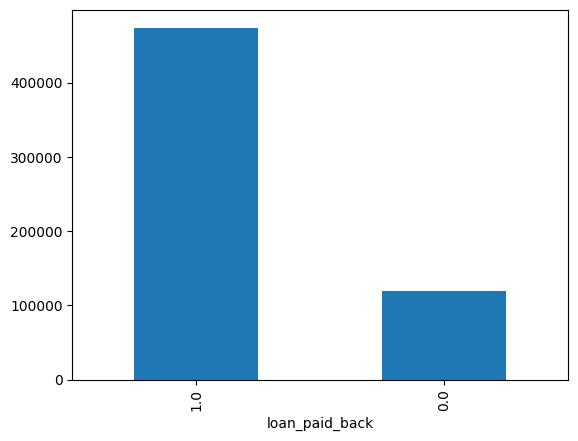

In [14]:
train_df['loan_paid_back'].value_counts().plot.bar()

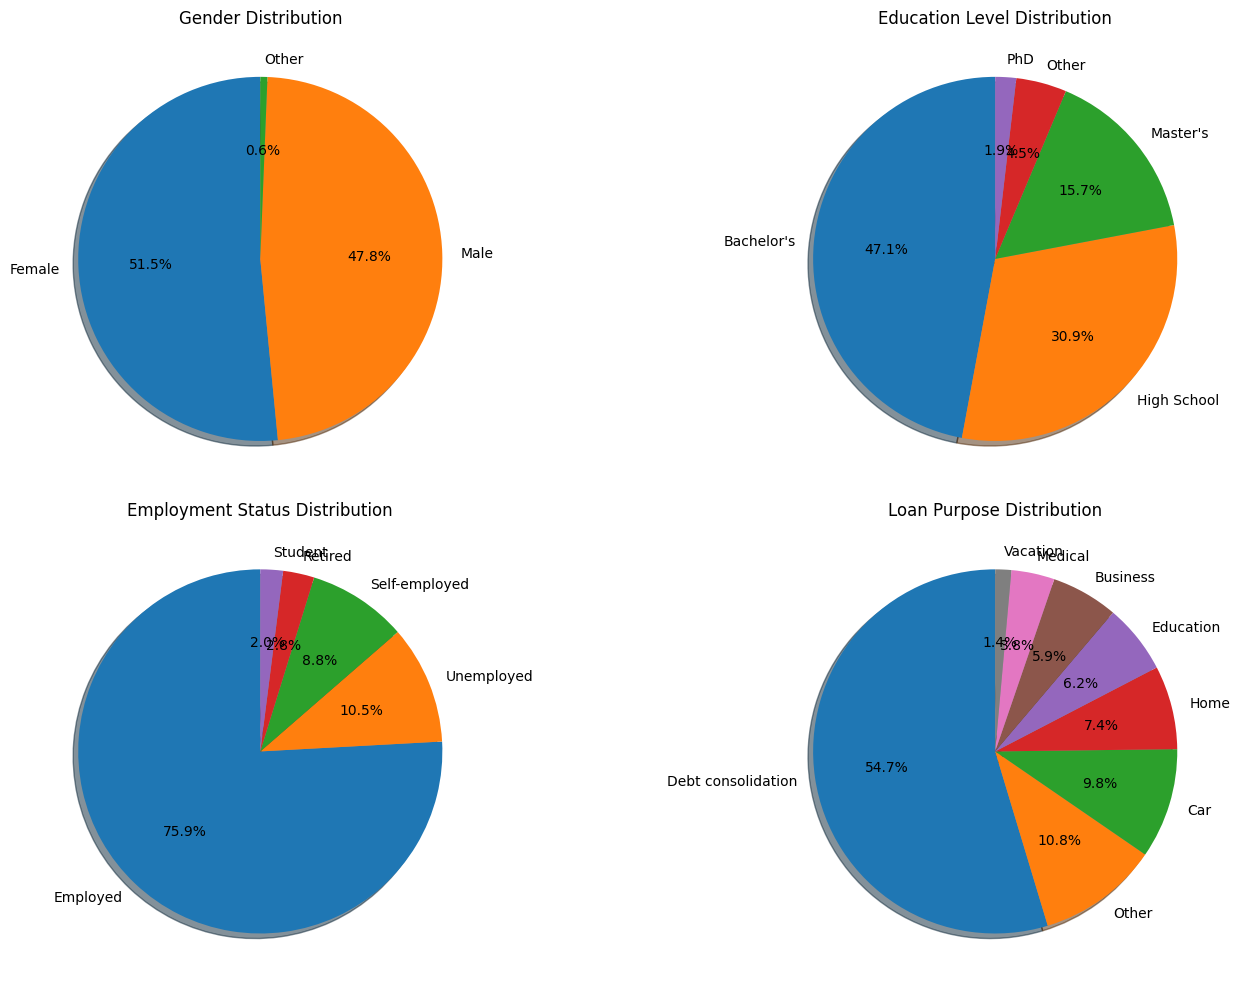

In [15]:
# Categorical columns
cols = ['gender', 'education_level',
        'employment_status', 'loan_purpose']

# Create 2x3 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Flatten axes array for easy looping
axes = axes.flatten()

# Loop through each categorical column
for i, col in enumerate(cols):
    train_df[col].value_counts().plot.pie(
        ax=axes[i],
        autopct='%1.1f%%',
        startangle=90,
        shadow=True
    )
    axes[i].set_title(f"{col.replace('_', ' ').title()} Distribution")
    axes[i].set_ylabel("")  # Hide y-axis label

# Remove any empty subplot (if less than 6)
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


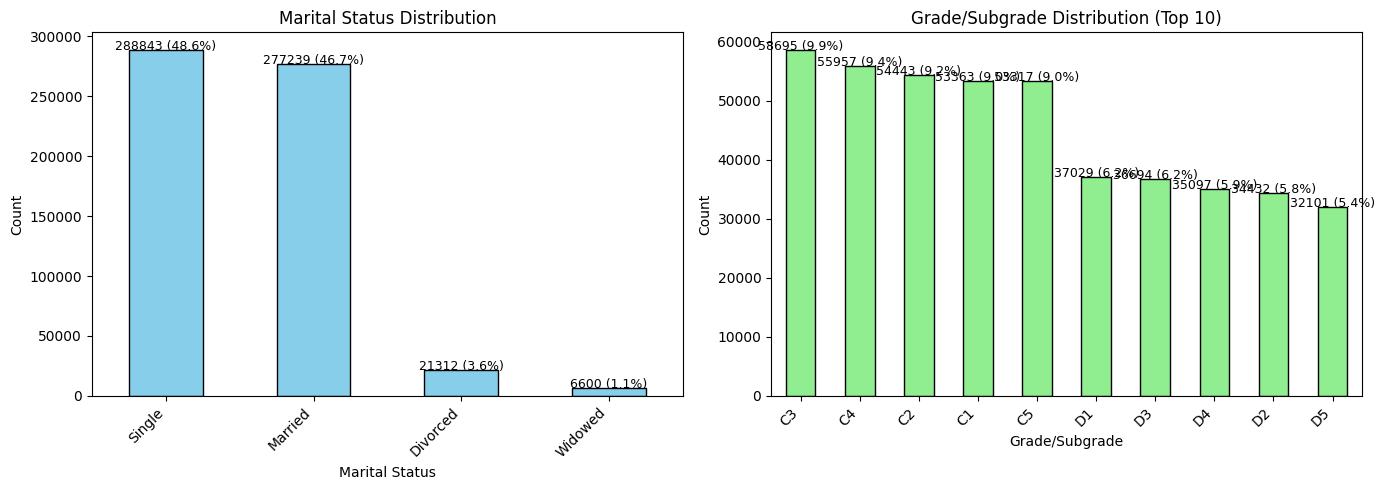

In [16]:
import matplotlib.pyplot as plt

# Prepare data
marital_counts = train_df['marital_status'].value_counts()
marital_perc = train_df['marital_status'].value_counts(normalize=True) * 100

grade_counts = train_df['grade_subgrade'].value_counts().head(10)  # top 10 for clarity
grade_perc = train_df['grade_subgrade'].value_counts(normalize=True).head(10) * 100

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Marital Status ---
bars1 = marital_counts.plot.bar(ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title("Marital Status Distribution")
axes[0].set_xlabel("Marital Status")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
for i, (count, pct) in enumerate(zip(marital_counts.values, marital_perc.values)):
    axes[0].text(i, count + 0.5, f'{count} ({pct:.1f}%)', ha='center', fontsize=9)

# --- Grade/Subgrade ---
bars2 = grade_counts.plot.bar(ax=axes[1], color='lightgreen', edgecolor='black')
axes[1].set_title("Grade/Subgrade Distribution (Top 10)")
axes[1].set_xlabel("Grade/Subgrade")
axes[1].set_ylabel("Count")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
for i, (count, pct) in enumerate(zip(grade_counts.values, grade_perc.values)):
    axes[1].text(i, count + 0.5, f'{count} ({pct:.1f}%)', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


## Feature Engineering

In [17]:
# since id is not going to play role in the payback of the loan, we can drop it.
train_df.drop('id', axis=1, inplace=True)
train_df.sample(1)

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
528457,56984.41,0.078,708,4488.69,13.04,Female,Married,Bachelor's,Employed,Debt consolidation,C1,1.0


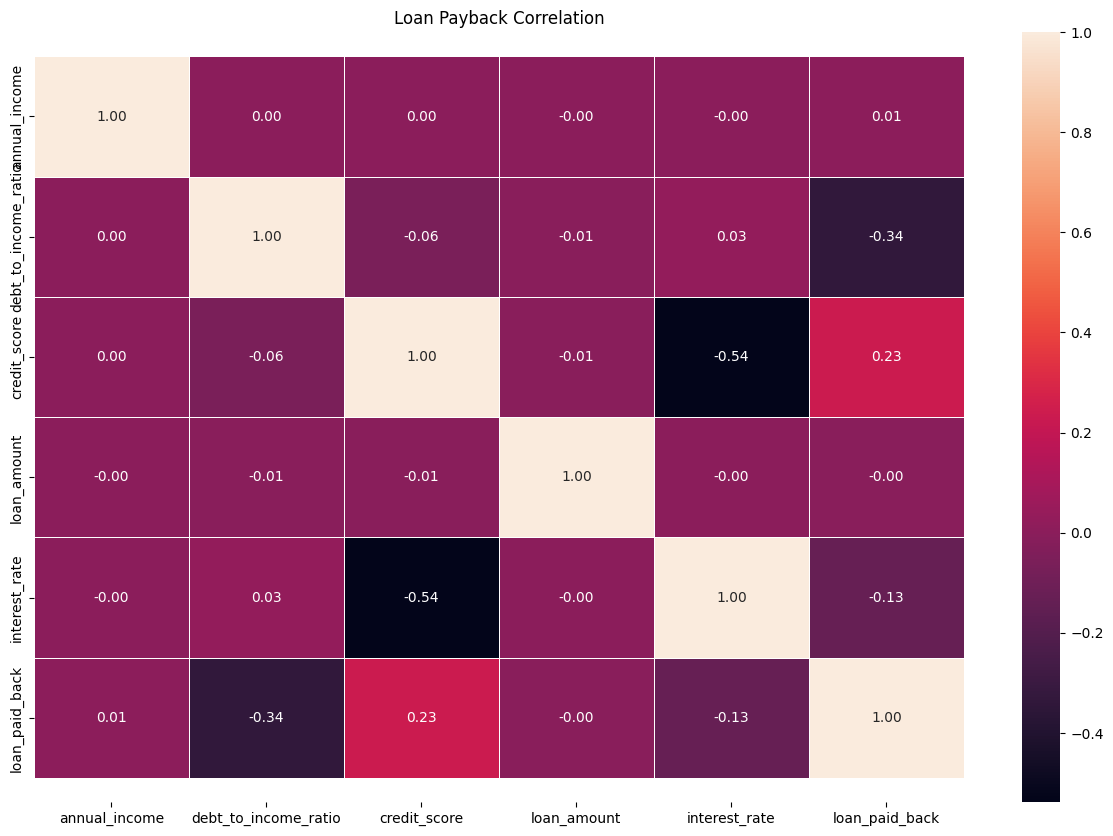

In [18]:
# Compute correlation matrix
corr_matrix = train_df.corr(numeric_only=True)

# Plot heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    linewidths=0.5,
    fmt=".2f",
    cmap="rocket",
    ax=ax
)

# Fix y-axis cut-off issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.2, top - 0.2)

plt.title("Loan Payback Correlation", fontsize=12)
plt.show()

# Calculating Risk base on different Criteria
